In [1]:
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append("..")
from dataset import Pipeline, Batch, action, model, inbatch_parallel, DatasetIndex, Dataset

from linknet_model import LinkNetModel
from nmnist import NoisedMnist
from plot_functions import plot_examples

In [2]:
SIZE = 64

In [3]:
MNIST_SIZE = 65000
BATCH_SIZE = 512
MAX_ITER = 100

In [4]:
level = 1           # интенсивность шума ([0, 1])
n_fragments = 40    # количество шумовых фрагментов   
size = 5            # размер шумового фрагмента (1, ..., 27)
distr = 'normal'    # распределение шумовых фрагментов на изображении ('normal' или 'uniform')

In [5]:
# создадим индекс и датасет для построения пайплайна

ind = DatasetIndex(np.arange(MNIST_SIZE))
mnistset = Dataset(ind, batch_class=NoisedMnist)
mnistset.cv_split([0.9, 0.1])

In [6]:
load_template = (Pipeline()
                 .load_images()
                 .random_location(SIZE)
                 .create_mask()
                 .add_noise('mnist_noise', level, n_fragments, size, distr))

train_feed_dict = {'image': 'images',
                  'mask': 'masks',
                  'mode': True}

test_feed_dict = {'image': 'images',
                  'mask': 'masks',
                  'mode': False}

In [7]:
ppl_train = ((load_template << mnistset.train)
            .init_variable('train_loss_history', init_on_each_run=list)
            .init_model('static', 
                        LinkNetModel, 
                        'linknet',
                        config={'loss': 'sigmoid_cross_entropy',
                                'optimizer': 'Adam',
                                'image_size': SIZE})
            .train_model('linknet', 
                         fetches='loss', 
                         feed_dict=train_feed_dict,
                         append_to='train_loss_history'))

ppl_test = ((load_template << mnistset.test)
            .import_model('linknet', ppl_train)
            .init_variable('predictions', init_on_each_run=list)
            .init_variable('test_loss_history', init_on_each_run=list)
            .predict_model('linknet', 
                           fetches='predicted_prob',
                           feed_dict=test_feed_dict,
                           append_to='predictions')
            .predict_model('linknet', 
                           fetches='loss',
                           feed_dict=test_feed_dict,
                           append_to='test_loss_history'))

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


In [8]:
# обучение

start = time()
for i in range(MAX_ITER):
    ppl_train.next_batch(BATCH_SIZE, n_epochs=None)
    ppl_test.next_batch(100, n_epochs=None)
    
    train_loss = ppl_train.get_variable('train_loss_history')[-1]
    test_loss = ppl_test.get_variable('test_loss_history')[-1]
    
    if (i+1) % 10 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, 
                                                                train_loss, 
                                                                test_loss))
stop = time()
print("Train time: {:05.3f} min".format((stop-start)/60))

Iter  10: train 1.166 test 1.151
Iter  20: train 1.027 test 1.018
Iter  30: train 0.929 test 0.917
Iter  40: train 0.842 test 0.830
Iter  50: train 0.762 test 0.757
Iter  60: train 0.689 test 0.686
Iter  70: train 0.622 test 0.614
Iter  80: train 0.560 test 0.555
Iter  90: train 0.505 test 0.499
Iter 100: train 0.457 test 0.451
Train time: 5.871 min


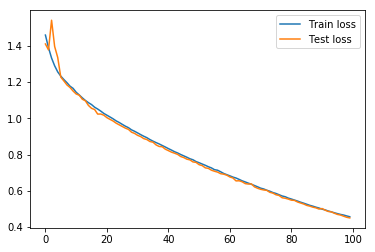

In [9]:
plt.plot(ppl_train.get_variable('train_loss_history'), label='Train loss')
plt.plot(ppl_train.get_variable('test_loss_history'), label='Test loss')
plt.legend()
plt.show()

In [10]:
images = []
masks = []
ppl_test.get_images(images).get_masks(masks).next_batch(10, n_epochs=None)
predictions = ppl_test.get_variable('predictions')[-1]

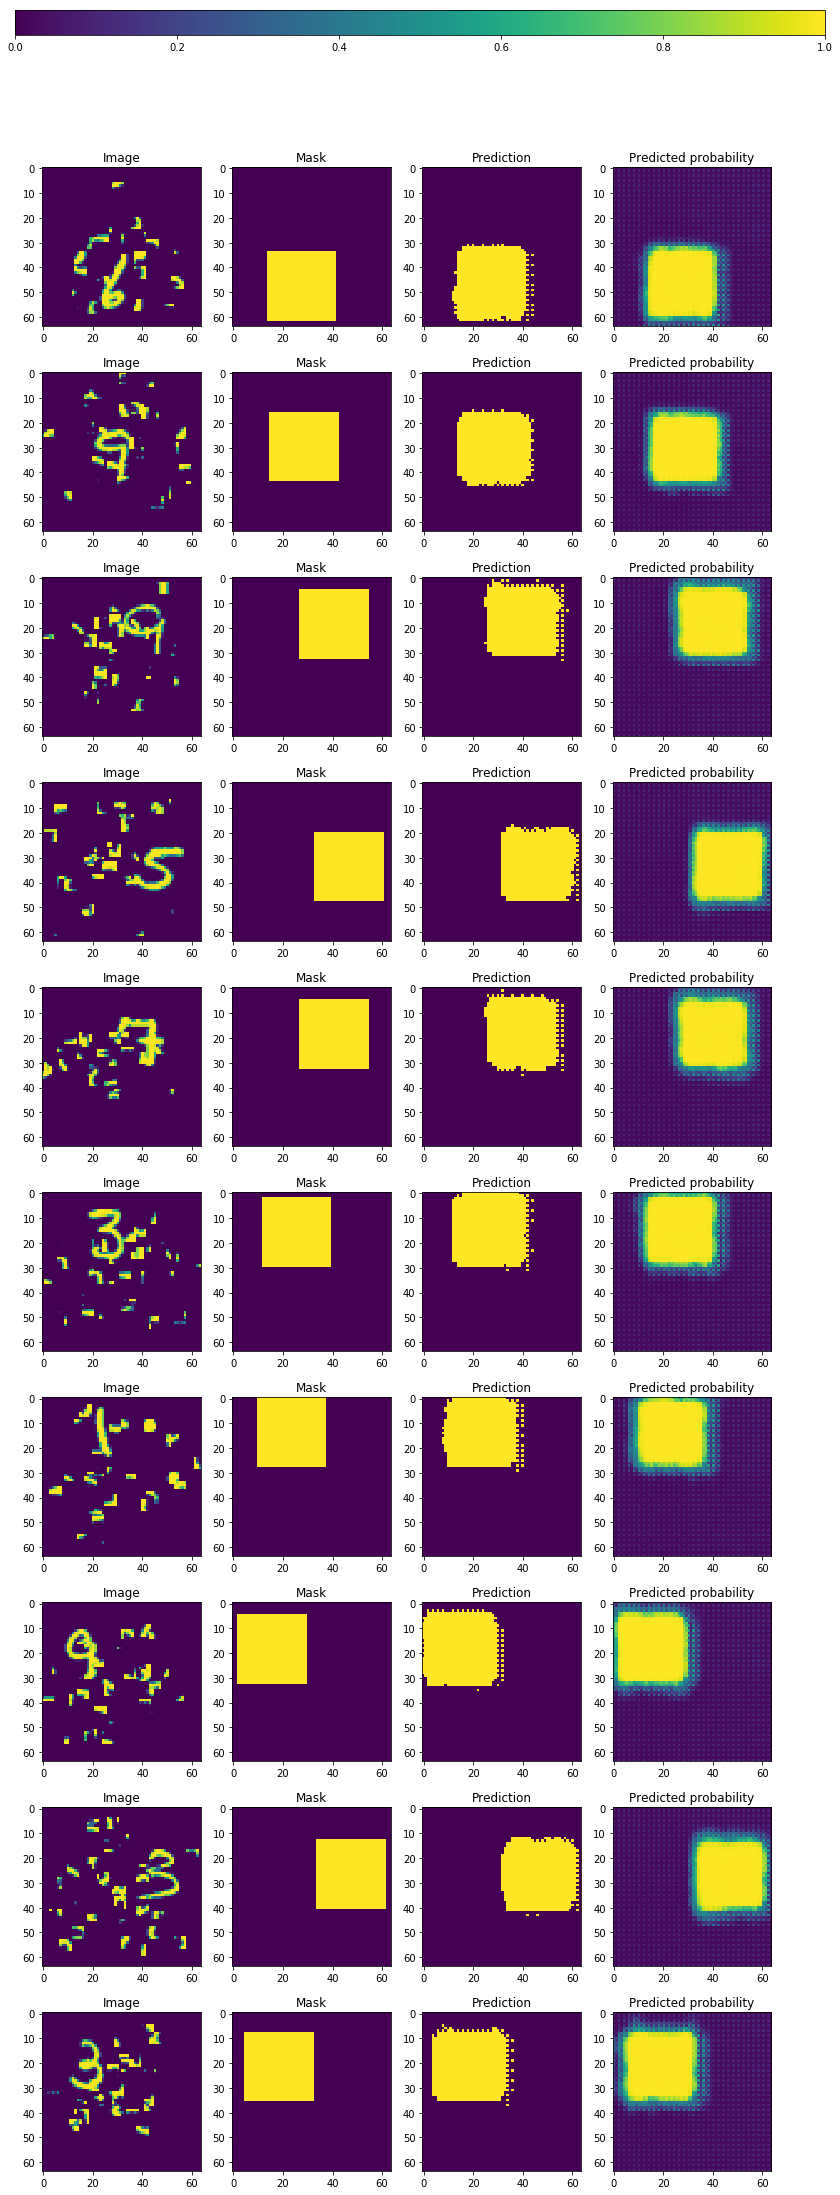

In [11]:
plot_examples(images, masks, predictions)